In [1]:
import igraph
import numpy
import matplotlib.pyplot as plt


def shrink(rx,ry):
    rx = numpy.array(rx)
    ry = numpy.array(ry)
    
    if rx[0]==rx[1]==rx[2] and ry[0]==ry[1]==ry[2]:
        rx = rx[0]+0.1*numpy.cos(numpy.linspace(0,2*numpy.pi,50))
        ry = ry[0]+0.1*numpy.sin(numpy.linspace(0,2*numpy.pi,50))
    else:
        rx = 0.75*rx+0.25*rx.mean()
        ry = 0.75*ry+0.25*ry.mean()
        
        rx = numpy.concatenate([
                numpy.linspace(rx[0],rx[0],41),
                numpy.linspace(rx[0],rx[1],20),
                numpy.linspace(rx[1],rx[2],20),
                numpy.linspace(rx[2],rx[2],41),])
        ry = numpy.concatenate([
                numpy.linspace(ry[0],ry[0],41),
                numpy.linspace(ry[0],ry[1],20),
                numpy.linspace(ry[1],ry[2],20),
                numpy.linspace(ry[2],ry[2],41)])

        filt = numpy.exp(-numpy.linspace(-2,2,41)**2)
        filt = filt / filt.sum()

        rx = numpy.convolve(rx,filt,mode='valid')
        ry = numpy.convolve(ry,filt,mode='valid')

    return rx,ry

def walks(A):
    w = []
    for v1 in numpy.arange(len(A)):
        for v2 in numpy.where(A[v1])[0]:
            for v3 in numpy.where(A[v2])[0]:
                w += [(v1,v2,v3)]
    return w

def layout(A,seed):
    graph = igraph.Graph()
    graph.add_vertices(len(A))
    graph.add_edges(zip(*numpy.where(A==1)))
    return numpy.array(list(graph.layout_kamada_kawai()))
    

In [2]:
import sys
import numpy
import random
import torch
import igraph
import matplotlib.pyplot as plt


In [19]:
# Function to generate a BA graph
def scalefreegraph(seed=0,embed=False,growth=None):
    random = numpy.random.mtrand.RandomState(seed)
    N = 10
    A = numpy.zeros([N,N])
    A[1,0] = 1
    A[0,1] = 1
    growth = growth if growth is not None else random.randint(1,3)
    N0 = 2
    for i in range(N0,N):
        if   growth==1: tt = 1   # Barabasi-Albert 1
        elif growth==2: tt = 2   # Barabasi-Albert 2
        else:
            tt = 1 + 1*((growth-1)>random.uniform(0,1))
        p = A.sum(axis=0)/A.sum()
        for j in random.choice(N,tt,p=p,replace=False):
            A[i,j] = 1
            A[j,i] = 1
    r = random.permutation(len(A))
    A = A[r][:,r]*1.0

    # Add Self-Connections
    A = A + numpy.identity(len(A))

    # Build Data Structures
    D = A.sum(axis=1)
    L = torch.FloatTensor(A/(numpy.outer(D,D)**.5+1e-9)) # laplacian

    return {
        'adjacency':torch.FloatTensor(A),
        'laplacian':L,
        'target':growth,
        'layout':layout(A,seed) if embed else None,
        'walks':walks(A)
    }


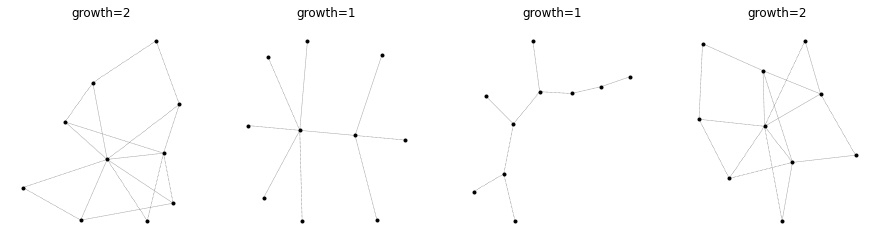

In [20]:
sample_ids = [1,3,4,5]
####################

# Function to visualise a graph
def vis_graph(g, ax):
    # Arange graph layout
    r = g['layout']
    r = r - r.min(axis=0)
    r = r / r.max(axis=0) * 2 - 1

    # Plot the graph
    N = len(g['adjacency'])
    for i in numpy.arange(N):
        for j in numpy.arange(N):
            if g['adjacency'][i,j] > 0 and i != j: plt.plot([r[i,0], r[j,0]], [r[i,1], r[j,1]], color='gray', lw=0.5, ls='dotted')
    ax.plot(r[:,0],r[:,1],'o',color='black',ms=3)

# Plotting
plt.figure(figsize=(3*len(sample_ids), 3))
for ids, seed in enumerate(sample_ids):
    ax =plt.subplot( 1,len(sample_ids), ids+1)
    sfg = scalefreegraph(seed=seed, embed=True)

    vis_graph(sfg, ax=ax)
    plt.subplots_adjust(left=0,right=1,bottom=0,top=1)

    plt.axis('off')
    plt.xlim(-1.2,1.2)
    plt.ylim(-1.2,1.2)
    ax.set_title('growth={}'.format( sfg['target']))

plt.show()
plt.close()


In [21]:
class GraphNet:
    def __init__(self,d,h,c):
        self.U  = torch.nn.Parameter(torch.FloatTensor(numpy.random.normal(0,d**-.5,[d,h])))
        self.W1 = torch.nn.Parameter(torch.FloatTensor(numpy.random.normal(0,h**-.5,[h,h])))
        self.W2 = torch.nn.Parameter(torch.FloatTensor(numpy.random.normal(0,h**-.5,[h,h])))
        self.V  = torch.nn.Parameter(torch.FloatTensor(numpy.random.normal(0,h**-.5,[h,c])))
        self.params = [self.U,self.W1,self.W2,self.V]

    def forward(self,A):
        H = torch.eye(len(A))
        H = H.matmul(self.U).clamp(min=0)
        H = (A.transpose(1,0).matmul(H.matmul(self.W1))).clamp(min=0)
        H = (A.transpose(1,0).matmul(H.matmul(self.W2))).clamp(min=0)
        H = H.matmul(self.V).clamp(min=0)
        return H.mean(dim=0)

    def lrp(self,A,gamma,l,inds):
        if inds is not None:
            j,k = inds
            Mj = torch.FloatTensor(numpy.eye(len(A))[j][:,numpy.newaxis])
            Mk = torch.FloatTensor(numpy.eye(len(A))[k][:,numpy.newaxis])

        W1p = self.W1+gamma*self.W1.clamp(min=0)
        W2p = self.W2+gamma*self.W2.clamp(min=0)
        Vp  = self.V+gamma*self.V.clamp(min=0)

        X = torch.eye(len(A))
        X.requires_grad_(True)

        H  = X.matmul(self.U).clamp(min=0)

        Z  = A.transpose(1,0).matmul(H.matmul(self.W1))
        Zp = A.transpose(1,0).matmul(H.matmul(W1p))
        H  = (Zp*(Z/(Zp+1e-6)).data).clamp(min=0)

        if inds is not None: H = H * Mj + (1-Mj) * (H.data)

        Z  = A.transpose(1,0).matmul(H.matmul(self.W2))
        Zp = A.transpose(1,0).matmul(H.matmul(W2p))
        H  = (Zp*(Z/(Zp+1e-6)).data).clamp(min=0)

        if inds is not None: H = H * Mk + (1-Mk) * (H.data)

        Z  = H.matmul(self.V)
        Zp = H.matmul(Vp)
        H  = (Zp*(Z/(Zp+1e-6)).data).clamp(min=0)

        Y = H.mean(dim=0)[l]

        Y.backward()

        return X.data*X.grad


In [22]:
def train_scalefree():
    model = GraphNet(10,64,2)
    optimizer = torch.optim.SGD(model.params, lr=0.001, momentum=0.99)
    erravg = 0.5
    print('Train model:')
    print('   iter | err')
    print('   -----------')
    for it in range(0,20001):
        optimizer.zero_grad()
        g = scalefreegraph(seed=it, embed=False)
        y = model.forward(g['laplacian'])
        err = (y[0]-(g['target']==1)*1.0)**2 + (y[1]-(g['target']==2)*1.0)**2
        erravg = 0.999*erravg + 0.001*err.data.numpy()
        err.backward()
        optimizer.step()
        if it%1000==0:
            print('% 8d %.3f'%(it,erravg))
    return model


In [23]:
model = train_scalefree()

Train model:
   iter | err
   -----------
       0 0.500
    1000 0.599
    2000 0.320
    3000 0.128
    4000 0.054
    5000 0.024
    6000 0.012
    7000 0.008
    8000 0.007
    9000 0.007
   10000 0.006
   11000 0.005
   12000 0.005
   13000 0.005
   14000 0.005
   15000 0.005
   16000 0.004
   17000 0.004
   18000 0.004
   19000 0.004
   20000 0.003


In [24]:
test_size = 200

num_false = 0
for it in range(20001, 20001 + test_size):
    g = scalefreegraph(seed=it, embed=False)
    y = model.forward(g['laplacian'])
    prediction = int(y.data.argmax()) +1

    if prediction != g['target']: num_false += 1

print('For {} test samples, the model predict the growth parameter with an accuracy of {} %'.format(test_size, 100 * (test_size - num_false)/test_size))


For 200 test samples, the model predict the growth parameter with an accuracy of 100.0 %


In [25]:
def explain(g, nn, t, gamma=None, ax=None):
    # Arrange graph layout
    r = g['layout']
    r = r - r.min(axis=0)
    r = r / r.max(axis=0) * 2 - 1

    # Plot the graph
    N = len(g['adjacency'])
    for i in numpy.arange(N):
        for j in numpy.arange(N):
            if g['adjacency'][i,j] > 0 and i != j: plt.plot([r[i,0],r[j,0]],[r[i,1],r[j,1]], color='gray', lw=0.5, ls='dotted')
    ax.plot(r[:,0],r[:,1],'o',color='black',ms=3)

    for (i,j,k) in g['walks']:
        R = nn.lrp(g['laplacian'], gamma, t, (j,k))[i].sum()
        tx,ty = shrink([r[i,0],r[j,0],r[k,0]],[r[i,1],r[j,1],r[k,1]])

        if R > 0.0:
            alpha = numpy.clip(20*R.data.numpy(),0,1)
            ax.plot(tx,ty,alpha=alpha,color='red',lw=1.2)

        if R < -0.0:
            alpha = numpy.clip(-20*R.data.numpy(),0,1)
            ax.plot(tx,ty,alpha=alpha,color='blue',lw=1.2)


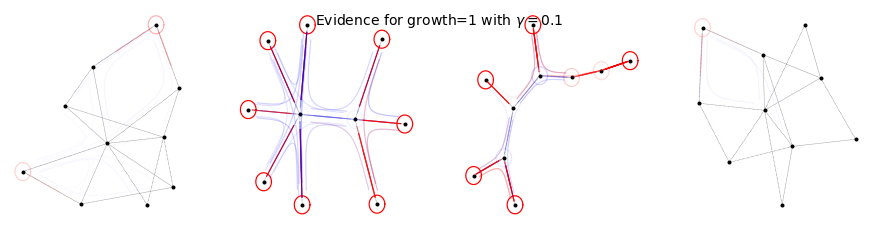

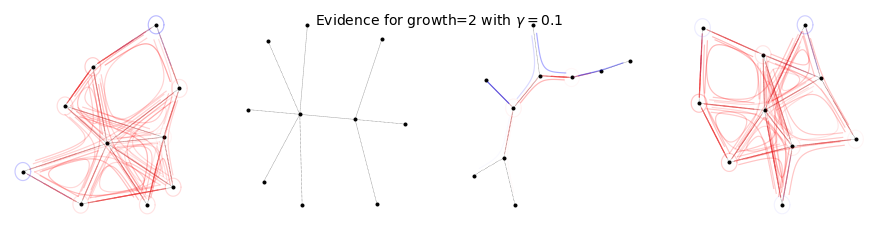

In [26]:
gamma=0.1

for target in [0,1]:
    plt.figure(figsize=(3*len(sample_ids), 3))
    for ids, seed in enumerate(sample_ids):
        ax =plt.subplot( 1,len(sample_ids), ids+1)
        sfg = scalefreegraph(seed=seed, embed=True)

        # Explain
        explain(sfg, model, target, gamma=gamma, ax=ax)
        plt.subplots_adjust(left=0,right=1,bottom=0,top=1)

        plt.axis('off')
        plt.xlim(-1.2,1.2)
        plt.ylim(-1.2,1.2)

    plt.suptitle('Evidence for growth={} with $\gamma={}$'.format(target+1, gamma), size=14)
    plt.show()
    plt.close()
